In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
from time import sleep
import STAGATE

In [6]:
fd = ("../../MIST_additional_holdout/data/")
dns = ["MouseAD", "MouseWT", "Melanoma", "Prostate"]

In [22]:
os.mkdir("STAGATE_mclust_ST_input/")
os.mkdir("STAGATE_mclust_ST_output/")

In [24]:
df = pd.read_csv(f"../../MIST_additional_holdout/data/{dns[0]}/cluster_results_all_methods.csv")
n_clust = len(set(df.MIST))
n_clust

5

  0%|          | 0/4 [00:00<?, ?it/s]

------Calculating spatial graph...
The graph contains 4872 edges, 488 cells.
9.9836 neighbors per cell on average.
Size of Input:  (488, 3000)



 48%|██████████████████████████████████████████▏                                             | 240/500 [00:07<00:07, 32.62it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████▉  | 488/500 [00:15<00:00, 31.88it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:15<00:00, 32.04it/s]


MouseAD 5


Package 'mclust' version 5.4.9
Type 'citation("mclust")' for citing this R package in publications.


------Calculating spatial graph...
The graph contains 4514 edges, 447 cells.
10.0984 neighbors per cell on average.
Size of Input:  (447, 3000)



 48%|██████████████████████████████████████████▏                                             | 240/500 [00:07<00:07, 33.95it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████▉  | 488/500 [00:14<00:00, 33.87it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:14<00:00, 33.38it/s]


MouseWT 5


Package 'mclust' version 5.4.9
Type 'citation("mclust")' for citing this R package in publications.


------Calculating spatial graph...
The graph contains 3076 edges, 293 cells.
10.4983 neighbors per cell on average.
Size of Input:  (293, 3000)



 60%|████████████████████████████████████████████████████▊                                   | 300/500 [00:06<00:04, 44.55it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 43.61it/s]


Melanoma 5


Package 'mclust' version 5.4.9
Type 'citation("mclust")' for citing this R package in publications.


------Calculating spatial graph...
The graph contains 4424 edges, 406 cells.
10.8966 neighbors per cell on average.
Size of Input:  (406, 3000)



 48%|██████████████████████████████████████████▏                                             | 240/500 [00:06<00:07, 36.24it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████▉  | 488/500 [00:13<00:00, 35.65it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:14<00:00, 35.69it/s]


Prostate 5


Package 'mclust' version 5.4.9
Type 'citation("mclust")' for citing this R package in publications.


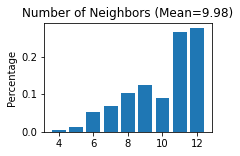

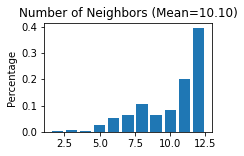

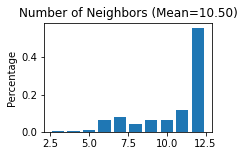

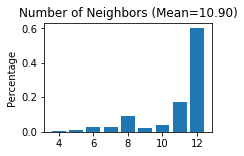

In [27]:
import anndata as ad
from tqdm.notebook import tqdm

for dn in tqdm(dns):
    # preprocessing
    adata = ad.read_text(os.path.join(fd, dn, 'raw.csv'),
                        delimiter=',',
                        first_column_names=True)
    xs, ys = [], []
    for idx in adata.obs_names.tolist():
        xs.append(int(idx.split("x")[0]))
        ys.append(int(idx.split("x")[1]))
    adata.obs['x'] = xs;
    adata.obs['y'] = ys;
    adata.obsm['spatial'] = adata.obs[['x', 'y']].copy()
    adata.var_names_make_unique()
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    # normalize
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    # run STAGATE
    STAGATE.Cal_Spatial_Net(adata, rad_cutoff=2)
    STAGATE.Stats_Spatial_Net(adata)
    adata = STAGATE.train_STAGATE(adata, alpha=0)
    STAGATE_df = pd.DataFrame(data=adata.obsm['STAGATE'], index=adata.obs_names)
    input_fn = f"STAGATE_mclust_ST_input/{dn}_STAGATE_obsm.csv"
    STAGATE_df.to_csv(input_fn)
    out_fn = f"STAGATE_mclust_ST_output/{dn}.csv"

    df = pd.read_csv(f"../../MIST_additional_holdout/data/{dns[0]}/cluster_results_all_methods.csv")
    n_clust = len(set(df.MIST))

    cmd = f'Rscript run_mclust.R --inpath {input_fn} --outpath {out_fn} --g {n_clust}'
    print(dn, n_clust)
    os.system(cmd)

In [21]:
data.obsm

AxisArrays with keys: spatial